# Computer Vision course

## Homework 3

### Part 2 - Mean Shift and Camshift applications for object tracking

In [1]:
import cv2
import os
import numpy as np
from PIL import Image
from time import time
import matplotlib.pyplot as plt

# change directory to the root
os.chdir('..')

In [2]:
from utils.data_manipulation import read_data, record_video
from utils.transformations import indexes

### Data loading

In [3]:
human_rgb = read_data('Human4', grayscale=False)
biker_rgb = read_data('Biker', grayscale=False)
walking_rgb = read_data('Walking2', grayscale=False)
girl_rgb = read_data('Girl', grayscale=False)
surfer_rgb = read_data('Surfer', grayscale=False)

Text(0.5, 1.0, 'Initial RoI\n(girl)')

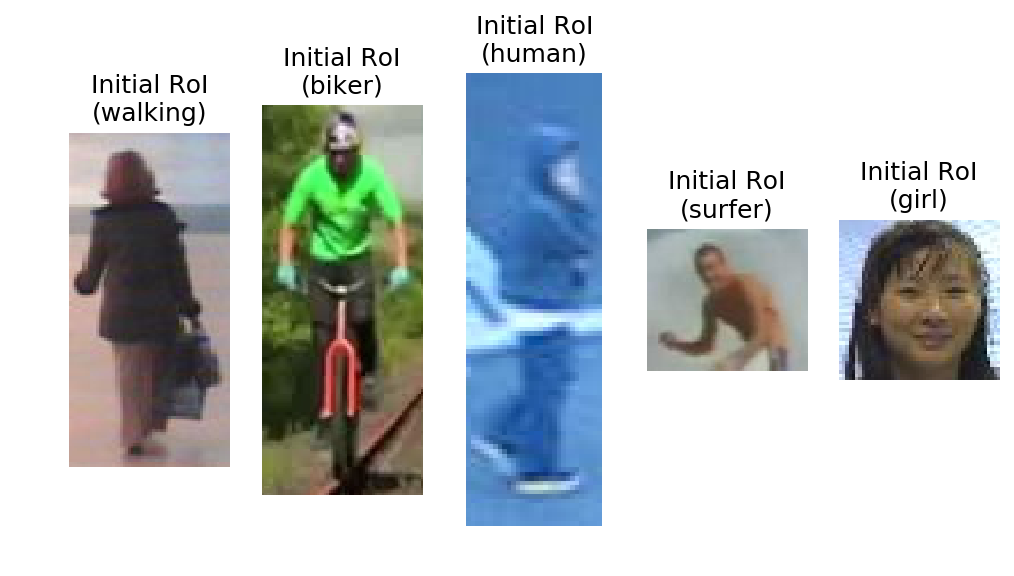

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(8, 4), dpi=150)

axes[0].imshow(walking_rgb[0][125:250, 120:180])
axes[0].axis('off')
axes[0].set_title('Initial RoI\n(walking)')

axes[1].imshow(biker_rgb[0][90:260, 235:305])
axes[1].axis('off')
axes[1].set_title('Initial RoI\n(biker)')

axes[2].imshow(human_rgb[0][225:325, 95:125])
axes[2].axis('off')
axes[2].set_title('Initial RoI\n(human)')

axes[3].imshow(surfer_rgb[0][130:210, 250:340])
axes[3].axis('off')
axes[3].set_title('Initial RoI\n(surfer)')

axes[4].imshow(girl_rgb[0][20:70, 45:95])
axes[4].axis('off')
axes[4].set_title('Initial RoI\n(girl)')

## Mean shift implementation

In [29]:
def get_centered_roi(center, roi):
    '''Move region of the interest
    to the new center.

    Parameters
    ----------
    center: np.ndarray, coordinate of the new center
    roi: tuple, the roi in form x0:x1, y0:y1

    -------
    Returns:
    roi: tuple, the new roi in form x0:x1, y0:y1'''

    roi = list(roi)
    
    size_x = (roi[1] - roi[0]) // 2
    size_y = (roi[3] - roi[2]) // 2
    
    # build roi around new center
    roi[0] = int(center[0] - size_x)
    roi[1] = int(center[0] + size_x)
    roi[2] = int(center[1] - size_y)
    roi[3] = int(center[1] + size_y)
        
    roi = tuple(roi)
    
    return roi

def mean_shift(image, roi):
    '''Vanilla implementation of the mean shift
    algorithm for image data

    Parameters
    ----------
    image: np.ndarray, two dimensional array
    roi: tuple, the roi in form x0:x1, y0:y1

    -------
    Returns:
    roi: tuple, the new roi in form x0:x1, y0:y1'''
    
    num_of_iters = 20
    min_dist = 1
    centroid = np.zeros(2)
    
    # the possible min and max
    # values for new center coordinates
    # depend on the size of window
    min_x = (roi[1] - roi[0]) // 2
    max_x = image.shape[0] - min_x
    
    min_y = (roi[3] - roi[2]) // 2
    max_y = image.shape[1] - min_y
    
    centroid = np.zeros(2)
    
    for _ in range(num_of_iters):
        
        template = image[roi[0]:roi[1],
                         roi[2]:roi[3]]
        
        # create from template probability distribution
        tmp = template / template.sum()
        
        # find mean shift within window's distribution
        centroid_x = (tmp.sum(axis=1) * np.arange(template.shape[0])).sum()
        centroid_y = (tmp.sum(axis=0) * np.arange(template.shape[1])).sum()

        next_centroid = np.array([centroid_x.clip(min=min_x, max=max_x),
                                  centroid_y.clip(min=min_y, max=max_y)])
        
        if np.linalg.norm(centroid - next_centroid) < min_dist:
            break
        else:
            centroid = next_centroid.copy()
        
        # move
        roi = get_centered_roi(centroid, roi)
            
    return roi

def compute_hist(image, roi):
    '''Compute the histogram of the
    region of interest in the HSV
    color space

    Parameters
    ----------
    image: np.ndarray, rgb image
    roi: tuple, the roi in form x0:x1, y0:y1

    -------
    Returns:
    roi_hist: histogram of the roi'''
    
    template = image[roi[0]:roi[1],
                     roi[2]:roi[3]]
    
    # transform RGB -> HSV
    hsv_template = cv2.cvtColor(template, cv2.COLOR_RGB2HSV)
    
    # mask for histogram: delete pixels with meaningful value and saturation
    mask = cv2.inRange(hsv_template, np.array([0, 60, 32]), np.array([180, 255, 255]))
    
    # compute hist
    roi_hist = cv2.calcHist([hsv_template], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
    
    return roi_hist

def to_opencv_roi(roi):
    '''Convert roi in custom
    formalism to OpenCV format

    Parameters
    ----------
    roi: tuple, the roi in form x0:x1, y0:y1

    -------
    Returns:
    result: tuple, the new roi in form y0:x0, h:w'''
    result = (roi[2], roi[0], roi[3] - roi[2], roi[1] - roi[0])
    
    return result
    
def from_opencv_roi(roi):
    '''Convert roi in OpenCV
    formalism to custom format

    Parameters
    ----------
    roi: tuple, the roi in form y0:x0, h:w

    -------
    Returns: tuple, the new roi in form x0:x1, y0:y1'''
    result = (roi[1], roi[1] + roi[3], roi[0], roi[0] + roi[2])
    
    return result

In [30]:
def tracking_mean_shift_custom(video, initial_roi):
    '''Mean Shift custom tracker
    
    Parameters
    ----------
    video: np.ndarray, 4D video
    initial_roi: tuple, the roi in form x0:x1, y0:y1
    
    -------
    Returns: rois, list of the rois in format x0:x1, y0:y1
    '''
    
    # compute histogram of the template
    rois = [initial_roi]
    roi_hist = compute_hist(video[0], initial_roi)
    
    for i in range(1, len(video)):
        
        roi = rois[-1]
        
        # compute the Back projection of image
        # i.e apply histogram on the image and obtain almost
        # probability distribution (up to the constant)
        hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        roi_next = mean_shift(dst, roi)
        
        rois.append(roi_next)
        
    return rois

def tracking_mean_shift_opencv(video, initial_roi):
    '''Mean Shift OpenCV tracker wrapper
    
    Parameters
    ----------
    video: np.ndarray, 4D video
    initial_roi: tuple, the roi in form x0:x1, y0:y1
    
    -------
    Returns: rois, list of the rois in format x0:x1, y0:y1
    '''
    rois = [initial_roi]
    roi_hist = compute_hist(video[0], initial_roi)
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
    
    for i in range(1, len(video)):
        
        roi = to_opencv_roi(rois[-1])
        # compute the Back projection of image
        # i.e apply histogram on the image and obtain almost
        # probability distribution (up to the constant)
        hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        
        _, roi_next = cv2.meanShift(dst, tuple(roi), term_crit)
        roi_next = from_opencv_roi(roi_next)
        rois.append(roi_next)
        
    return rois

def tracking_camshift_opencv(video, initial_roi):
    '''CAMShift OpenCV tracker wrapper
    
    Parameters
    ----------
    video: np.ndarray, 4D video
    initial_roi: tuple, the roi in form x0:x1, y0:y1
    
    -------
    Returns: rois, list of the rois in format x0:x1, y0:y1
    '''
    rois = [initial_roi]
    roi_hist = compute_hist(video[0], initial_roi)
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
    
    for i in range(1, len(video)):
        
        roi = to_opencv_roi(rois[-1])
        # compute the Back projection of image
        # i.e apply histogram on the image and obtain almost
        # probability distribution (up to the constant)
        hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        
        _, roi_next = cv2.CamShift(dst, tuple(roi), term_crit)
        roi_next = from_opencv_roi(roi_next)
        rois.append(roi_next)
        
    return rois

## There are all videos in the folder mean_shift/
### But you can generate all this videos via running next sells:

### Biker

In [34]:
rois = tracking_camshift_opencv(biker_rgb, (90, 260, 235, 305))
record_video(rois, biker_rgb, 'biker-camshift-opencv')

In [441]:
rois = tracking_mean_shift_opencv(biker_rgb, (90, 260, 235, 305))
record_video(rois, biker_rgb, 'biker-meanshift-opencv')

In [442]:
rois = tracking_mean_shift_custom(biker_rgb, (90, 260, 235, 305))
record_video(rois, biker_rgb, 'biker-meanshift-custom')

### Girl

In [443]:
rois = tracking_camshift_opencv(girl_rgb, (20, 70, 45, 95))
record_video(rois, girl_rgb, 'girl-camshift-opencv')

In [444]:
rois = tracking_mean_shift_opencv(girl_rgb, (20, 70, 45, 95))
record_video(rois, girl_rgb, 'girl-meanshift-opencv')

In [445]:
rois = tracking_mean_shift_custom(girl_rgb, (20, 70, 45, 95))
record_video(rois, girl_rgb, 'girl-meanshift-custom')

### Human

In [446]:
rois = tracking_camshift_opencv(human_rgb, (225, 325, 95, 125))
record_video(rois, human_rgb, 'human-camshift-opencv')

In [447]:
rois = tracking_mean_shift_opencv(human_rgb, (225, 325, 95, 125))
record_video(rois, human_rgb, 'human-meanshift-opencv')

In [448]:
rois = tracking_mean_shift_custom(human_rgb, (225, 325, 95, 125))
record_video(rois, human_rgb, 'human-meanshift-custom')

### Walking woman 

In [38]:
rois = tracking_camshift_opencv(walking_rgb, (125, 250, 120, 180))
record_video(rois, walking_rgb, 'walking-camshift-opencv')

In [39]:
rois = tracking_mean_shift_opencv(walking_rgb, (125, 250, 120, 180))
record_video(rois, walking_rgb, 'walking-meanshift-opencv')

In [40]:
rois = tracking_mean_shift_custom(walking_rgb, (125, 250, 120, 180))
record_video(rois, walking_rgb, 'walking-meanshift-custom')

### Surfer

In [41]:
rois = tracking_camshift_opencv(surfer_rgb, (130, 210, 250, 340))
record_video(rois, surfer_rgb, 'surfer-camshift-opencv')

In [42]:
rois = tracking_mean_shift_opencv(surfer_rgb, (130, 210, 250, 340))
record_video(rois, surfer_rgb, 'surfer-mean-shift-opencv')

# Conclusion:

### The Mean-Shift algorithm works good when object clearly separated from background in the sense of colors distribution. For example, videos with Girl and Surfer demonstated the good ability of Mean Shift and Camshift as well to track objects. But in the other cases we must customize the mask when computing the histogram, i.e find out the typical colors of the objects by hands and fit this information in the model.